In [1]:
# Cell 1: Общее конфигурирование
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device("cuda")
print('Device:', device)
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "InvertedPendulum"
# ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"
ENV_ID = "InvertedPendulum-v5"
# ENV_ID = "Pendulum-v1"


Device: cuda


# Создание среды

In [2]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


2025-08-23 04:29:32,830 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [3]:
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor, is_acts_discrete
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

# если действия непрерывные, то число выходов нейросети нужно удвоить:
coef = 1 if is_acts_discrete(env.action_spec) else 2

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = act_dim * coef,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = 1
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
actor.to(device), critic.to(device)

obs_dim, act_dim

(4, 1)

In [4]:
env.action_spec

BoundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32,
    domain=continuous)

# Collector

In [5]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [6]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)

# Generate Paths

In [7]:
from agentslab.utils.misc import RunPaths, generate_paths

paths = generate_paths(ROOT, ALGO_NAME, ENV_NAME)
print(paths)

RunPaths(root=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab'), run_dir=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933'), ckpt_dir=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/checkpoints'), csv_train=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/csv_logs/train.csv'), csv_eval=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/csv_logs/eval.csv'), tb_train=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/tb_logs/train'), tb_eval=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/tb_logs/eval'), meta_yaml=WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/ppo_InvertedPendulum_20250823_042933/meta_info.yaml'))


# Loggers

In [8]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(paths.csv_train)
csv_logger_eval = CSVLogger(paths.csv_eval)
tb_logger_train = TBLogger(paths.tb_train)
tb_logger_eval = TBLogger(paths.tb_eval)

# Checkpointers

In [9]:
from agentslab.utils.checkpointers import CheckpointManager

statefuls = {
    "policy": actor,                # nn.Module
    "optimizer": optim,             # torch.optim.Optimizer
    "scheduler": scheduler,         # lr scheduler
    "replay": replay_buffer,        # TorchRL ReplayBuffer (если используете)
}

chkptr = CheckpointManager(
    ckpt_dir=paths.ckpt_dir,               # .../runs/<run_name>/checkpoints
    statefuls=statefuls,
    meta={"algo": ALGO_NAME, "env": ENV_ID},
    best_metric_key="return_mean",    # по какой метрике выбирать best
    mode="max",                            # "min" для ошибок/лоссов
    max_to_keep=5,
)

# Training Loop

In [ ]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy

max_grad_norm = 1.0
num_epochs = 10
sub_batch_size = 64
eval_every = 5

log_dict = dict()
passed_frames = 0

with progress_bar(total_frames, desc="PPO") as pbar:
    # --------------------------------------------------------------
    # Итерируемся по коллекторам, пока не наберём нужное число шагов
    for i, tensordict_data in enumerate(collector):
        # Учимся на партии данных
        for _ in range(num_epochs):
            # Advantage для PPO пересчитываем на каждом проходе
            advantage_module(tensordict_data)
            data_view = tensordict_data.reshape(-1)
            replay_buffer.extend(data_view.cpu())
            for _ in range(frames_per_batch // sub_batch_size):
                subdata = replay_buffer.sample(sub_batch_size)
                loss_vals = loss_module(subdata.to(device))
                loss_value = (
                      loss_vals["loss_objective"] 
                    + loss_vals["loss_critic"] 
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
                optim.step()
                optim.zero_grad()
        scheduler.step()            # Шаг LR-планировщика

        # --------------------------------------------------------------

        # Извлекаем метрики
        batch_frames = int(tensordict_data.get(("next", "reward")).numel())
        passed_frames = min(passed_frames + batch_frames, total_frames)
        log_dict['step'] = passed_frames
        log_dict["reward"] = tensordict_data["next", "reward"].mean().item()
        log_dict["step_count"] = tensordict_data["step_count"].max().item()
        log_dict["lr"] = optim.param_groups[0]["lr"]
        
        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict['step'])    # TensorBoard

        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"avg_reward": f"{log_dict["reward"]: .4f}",
             "max_step": int(log_dict["step_count"]),
             "lr": f"{log_dict["lr"]: .4e}"},
            refresh=False
        )

        # корректное число фреймов в партии

        if batch_frames > 0:
            remaining = pbar.total - pbar.n
            pbar.update(min(batch_frames, remaining))

        # -----------------------------------------------------------
        # Оценка после каждых eval_every партий
        if (i + 1) % eval_every == 0:
            eval_results = eval_policy(env, actor, episodes=5, progress=False)
            # pbar.write не ломает отрисовку прогресс-бара
            pbar.write(
                f'eval: avg reward = {eval_results["return_mean"]}, '
                f'max episode lengh = {eval_results["max_episode_lengh"]}'
            )
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard
            chkptr.save(step=log_dict['step'], metrics=eval_results, make_step_snapshot=True)
        

PPO:   0%|          | 0.00/10.0k [00:00<?, ?frames/s]

eval: avg reward = 84.0, max episode lengh = 85
eval: avg reward = 267.2, max episode lengh = 290


# Graphs

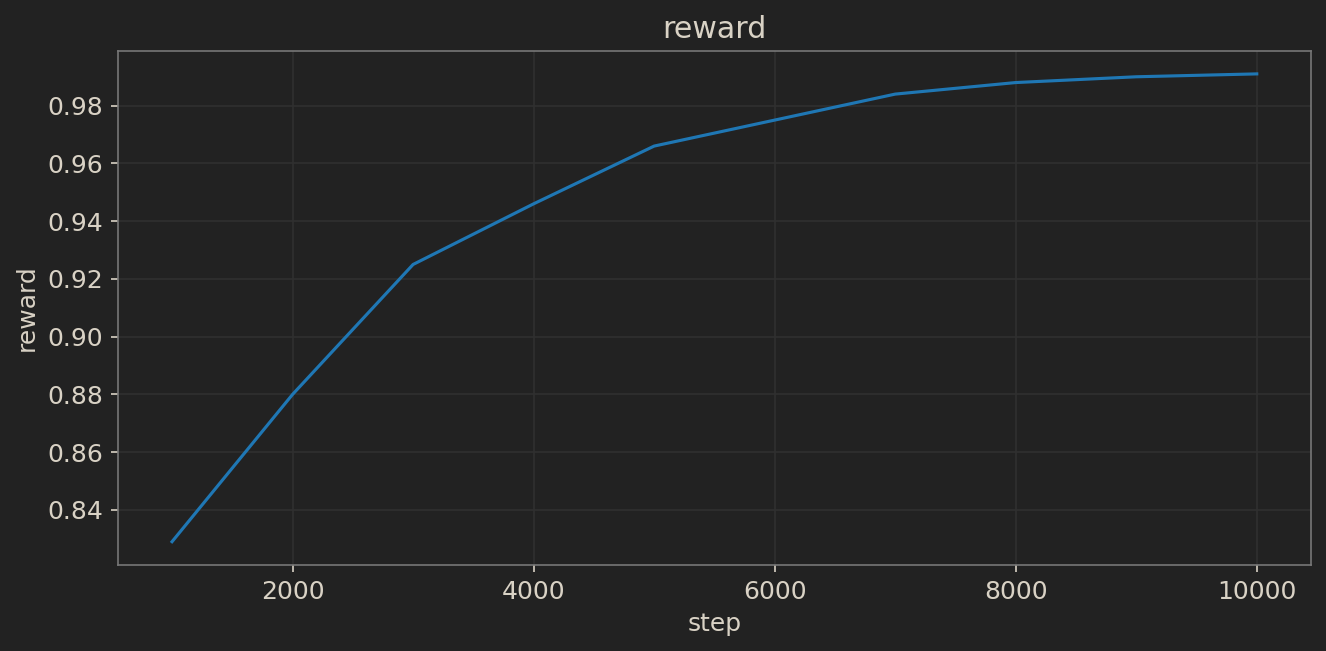

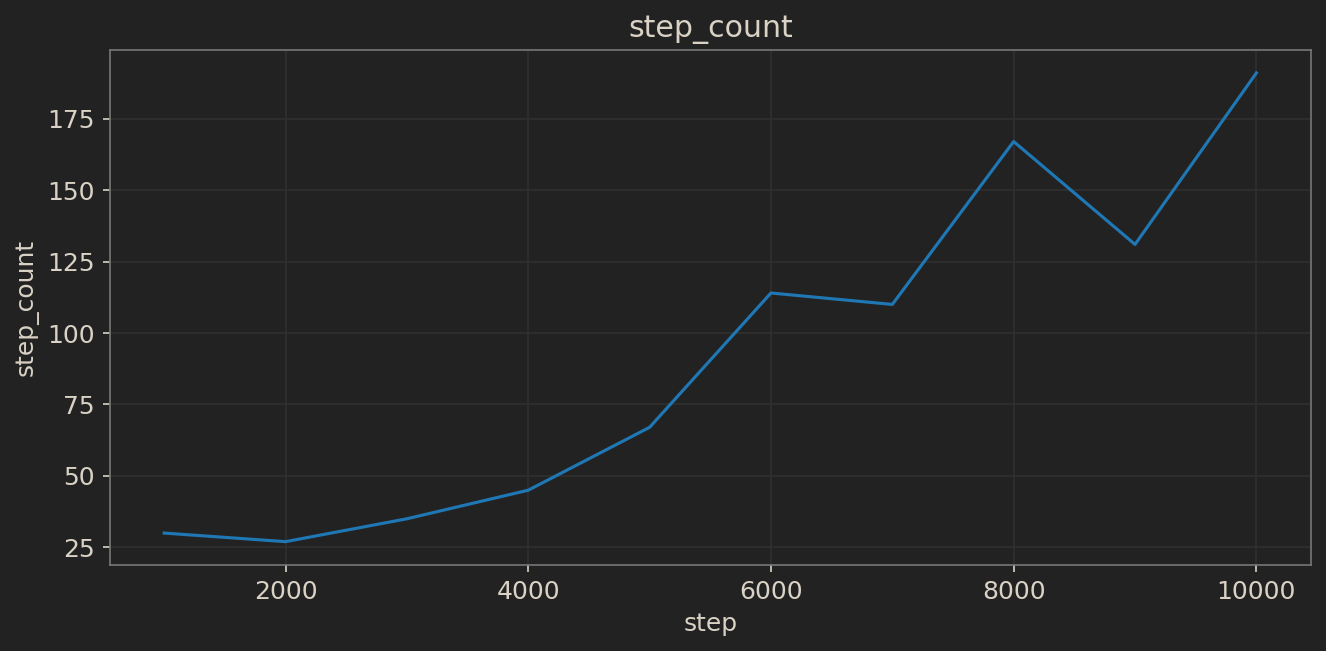

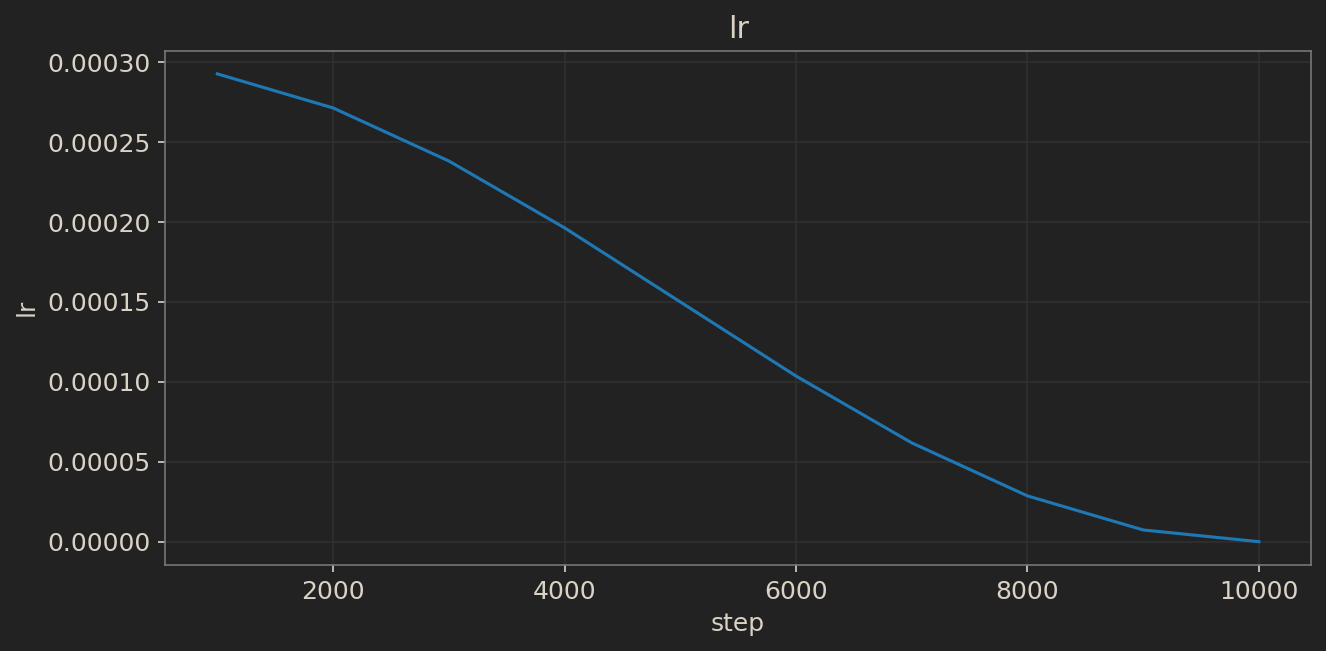

In [15]:
# Чтение последнего train.csv и построение графиков по каждой метрике
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ordevoir-dark")

csv_path = paths.csv_train  # объект paths из вашего кода (RunPaths.csv_train)

# Проверим наличие файла
if not csv_path.exists():
    raise FileNotFoundError(f"train.csv не найден по пути: {csv_path}")

# Читаем CSV (без агрессивных эвристик типов, чтобы избежать предупреждений)
df = pd.read_csv(csv_path, low_memory=False)

# Определим ось X: предпочитаем 'step', затем 'global_step', 'iteration', 'epoch'
x_candidates = [c for c in ["step", "global_step", "iteration", "epoch"] if c in df.columns]
x_col = x_candidates[0] if x_candidates else None

# Выбираем числовые столбцы, исключая ось X
num_cols = df.select_dtypes(include="number").columns.tolist()
if x_col in num_cols:
    num_cols.remove(x_col)

if not num_cols:
    raise ValueError(
        "В train.csv не найдено числовых метрик для построения графиков."
    )

# Строим отдельную диаграмму для каждой метрики
for col in num_cols:
    plt.figure(figsize=(9, 4.5))
    if x_col is not None:
        plt.plot(df[x_col], df[col])
        plt.xlabel(x_col)
    else:
        plt.plot(range(len(df)), df[col])
        plt.xlabel("index")
    plt.ylabel(col)
    plt.title(f"{col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Evaluating

In [13]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=10)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

{'return_mean': 272.9,
 'return_sum': 2729.0,
 'max_episode_lengh': 292,
 'num_episodes': 10}